In [16]:
%reload_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import pandas as pd
from astropy import units as u

from plato.instrument import DetectionModel

In [18]:
model = DetectionModel()

In [19]:
# calculate detection efficies on a grid of r_planet and porb
r_planet = np.linspace(0.3, 3.0, 1000) * u.Rearth
porb = np.geomspace(1, 2 * 365, 1000) * u.day

r_planet, porb = np.meshgrid(r_planet, porb)

df = pd.DataFrame(
    list(zip(r_planet.ravel().value, porb.ravel().value)), columns=["R_planet", "P_orb"]
)

In [20]:
df["R_star"] = 1
df["M_star"] = 1
df["Magnitude_V"] = 11
df["n_cameras"] = 24
df["cos_i"] = 0
df["sigma_star"] = 1e-6
df["u1"] = 0.4
df["u2"] = 0.5

eff = DetectionModel().detection_efficiency(df)

# shape df back to a grid
eff = eff.reshape(r_planet.shape)

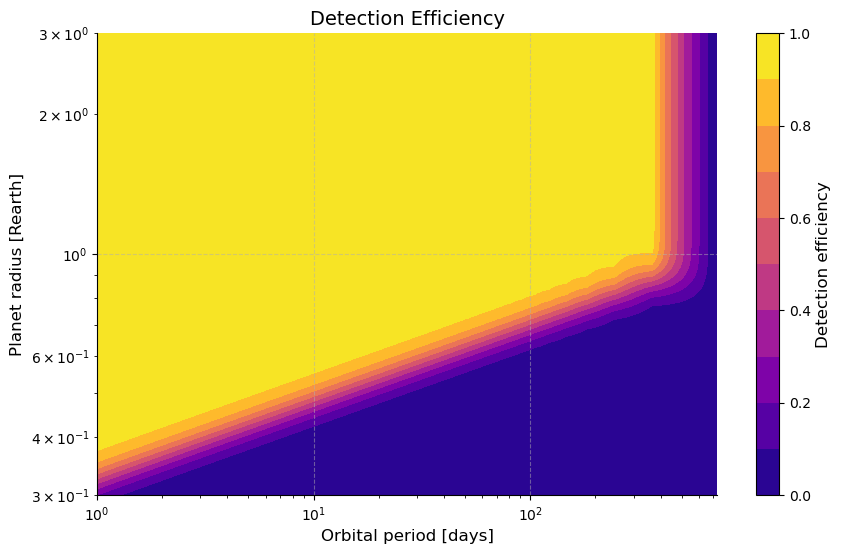

In [21]:
# plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Set the figure size

# Customize the contour plot
contour = plt.contourf(
    porb,
    r_planet,
    eff,
    levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    cmap="plasma",  # Set the color map
    # extend="both",  # Extend the color map beyond the data range
)

# Add labels and title
plt.xlabel("Orbital period [days]", fontsize=12)
plt.ylabel("Planet radius [Rearth]", fontsize=12)
plt.title("Detection Efficiency", fontsize=14)

# Add colorbar
cbar = plt.colorbar(contour)
cbar.set_label("Detection efficiency", fontsize=12)

# Set the scale of x and y axes
plt.xscale("log")
plt.yscale("log")

# Adjust tick labels font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove the top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add grid lines
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

In [22]:
from plato.stars import filter_valid_targets

data = pd.read_csv("../data/processed/LOPS2_targets.csv")
data = filter_valid_targets(data)

inp = data[["Radius", "Mass", "u1", "u2", "n_cameras"]].rename(
    columns={"Radius": "R_star", "Mass": "M_star", "n_cameras": "n_cameras"}
)

inp["R_planet"] = 1.0
inp["Magnitude_V"] = 11.0
inp["cos_i"] = np.random.uniform(0, 1, len(inp))
inp["P_orb"] = 365
inp["sigma_star"] = 10e-6

In [28]:
o = DetectionModel().detection_efficiency(data=inp)

19 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
np.isfinite(o).all()

True

In [25]:
np.sum(o)

36.47302780094815

In [26]:
o[o > 0]

array([6.99565621e-06, 1.88981100e-01, 3.64417092e-03, 6.65407656e-16,
       9.77780547e-02, 4.32844509e-14, 3.95141555e-01, 4.82202674e-13,
       2.09459002e-08, 8.35338446e-13, 2.91390872e-10, 4.28213555e-01,
       9.76378737e-23, 1.06822266e-01, 2.05130143e-13, 1.26996770e-04,
       2.23716918e-25, 1.00928904e-11, 3.21277740e-17, 7.73619124e-05,
       3.46465348e-17, 5.86534575e-07, 6.24135937e-21, 1.42083144e-04,
       3.60710142e-08, 3.82408907e-04, 8.22812475e-01, 9.28061129e-06,
       1.37653210e-02, 1.64991980e-05, 8.37179891e-01, 1.60081345e-12,
       3.85054896e-02, 1.16534254e-04, 9.60785379e-02, 4.88298611e-22,
       1.00547902e-04, 6.11801739e-10, 3.92399149e-10, 6.53803745e-24,
       5.43945266e-01, 1.95412536e-15, 1.01980420e-08, 6.49359061e-06,
       3.85397616e-07, 1.37581844e-09, 4.18674633e-07, 1.88735946e-11,
       1.19296537e-10, 1.52206594e-02, 3.76483823e-09, 2.99157658e-14,
       9.42738918e-02, 5.77566057e-11, 8.23851748e-17, 2.52162230e-02,
      

(array([  1.,   0.,   1.,   0.,   4.,   2.,  11.,  20.,  27.,  33.,  44.,
         48.,  66.,  71.,  85.,  88., 106., 126., 130., 127.]),
 array([-3.94437313e+01, -3.74728889e+01, -3.55020466e+01, -3.35312042e+01,
        -3.15603618e+01, -2.95895194e+01, -2.76186771e+01, -2.56478347e+01,
        -2.36769923e+01, -2.17061500e+01, -1.97353076e+01, -1.77644652e+01,
        -1.57936229e+01, -1.38227805e+01, -1.18519381e+01, -9.88109576e+00,
        -7.91025339e+00, -5.93941102e+00, -3.96856865e+00, -1.99772629e+00,
        -2.68839172e-02]),
 <BarContainer object of 20 artists>)

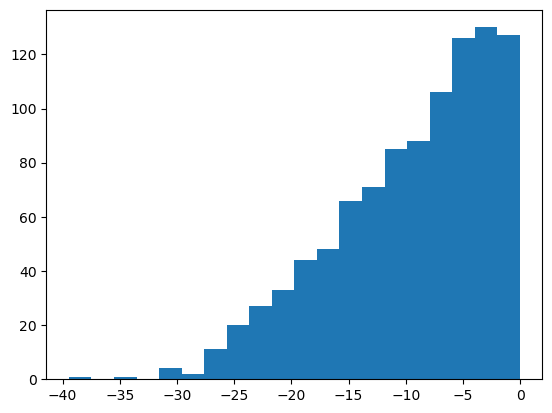

In [27]:
import matplotlib.pyplot as plt

plt.hist(np.log10(o[o > 0]), bins=20)